Tytuł projektu:



Członkowie zespołu:

Import potrzebnych bibliotek

In [ ]:
import json
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import pandas as pd
import xml.etree.ElementTree as ET
from matplotlib.patches import Rectangle
from collections import Counter
import seaborn as sns

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import albumentations as A
import cv2
import math
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn as nn

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="8fcEK5el2bIelQR39KUU")
project = rf.workspace("mohamed-attia-e2mor").project("pill-detection-llp4r")
dataset = project.version(1).download("voc")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.0 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=e3ac5f38f36c0236d8334aaaeb830a41645b8a771280c1c0a5cf4dd751bfd20b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
   

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Pill-Detection-1 in voc:: 100%|██████████| 905/905 [00:00<00:00, 1818.98it/s]


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Import bazy danych

In [ ]:
#stworzenie pliku json
dictionary = {"username":"zuzannak","key":"bf4a2eb8e60ebb5ff046b4810d024c90"}
with open("kaggle.json", "w") as outfile:
    json.dump(dictionary, outfile)
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

#pobranie datasetu
!kaggle datasets download -d perfect9015/pillsdetectiondataset

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          29410        819  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                               6KB  2023-05-28 18:26:48           2763         75  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           5126        106  1.0              
mohithsairamreddy/salary-data 

In [ ]:
with zipfile.ZipFile("pillsdetectiondataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [ ]:
for (dirpath, dirnames, filenames) in os.walk("/content/Pill-Detection-1"):
  for filename in filenames:
    if os.path.join(dirpath,filename).lower().endswith(('.png', '.jpg', '.jpeg')):
      os.replace(os.path.join(dirpath,filename), "/content/dataset/pillsPicture/images/"+filename)
    if os.path.join(dirpath,filename).lower().endswith('.xml'):
      os.replace(os.path.join(dirpath,filename), "/content/dataset/pillsPicture/annotations/"+filename)

#Przedstawienie obrazów i statystyk

In [ ]:
#utworzenie listy obrazów i annotacji
img_list = []
ann_list = []
for (dirpath, dirnames, filenames) in os.walk("dataset/pillsPicture/images"):
    for i, filename in enumerate(filenames):
      img_list.append(os.path.join(dirpath, filename))

for (dirpath, dirnames, filenames) in os.walk("dataset/pillsPicture/annotations"):
    for i, filename in enumerate(filenames):
      ann_list.append(os.path.join(dirpath, filename))

img_list.sort()
ann_list.sort()

print(img_list[0:3], ann_list[0:3])

['dataset/pillsPicture/images/20210702_160947_jpg.rf.0f2bb7c90c25859d86e1c85cea7496ec.jpg', 'dataset/pillsPicture/images/20210702_160950_jpg.rf.7b645ec7b162bbf9ed1e845ca6627666.jpg', 'dataset/pillsPicture/images/20210702_161003_jpg.rf.6a7de1c145dff9023fa91707c970cd5c.jpg'] ['dataset/pillsPicture/annotations/20210702_160947_jpg.rf.0f2bb7c90c25859d86e1c85cea7496ec.xml', 'dataset/pillsPicture/annotations/20210702_160950_jpg.rf.7b645ec7b162bbf9ed1e845ca6627666.xml', 'dataset/pillsPicture/annotations/20210702_161003_jpg.rf.6a7de1c145dff9023fa91707c970cd5c.xml']


In [ ]:
print(len(img_list))

602


##wyświetlenie obrazów

In [ ]:
def get_bboxes(path_to_ann):
  tree = ET.parse(path_to_ann)
  root = tree.getroot()

  annotations = []

  for bndbox in root.iter('bndbox'):
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    annotations.append([xmin, ymin, xmax, ymax])
  return annotations

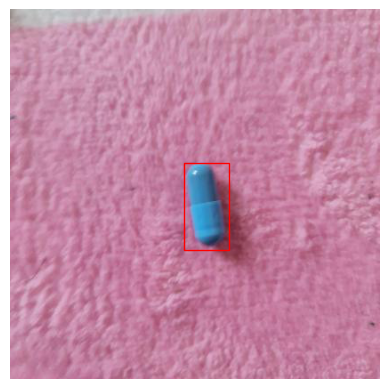

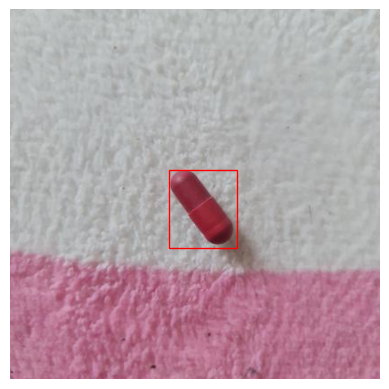

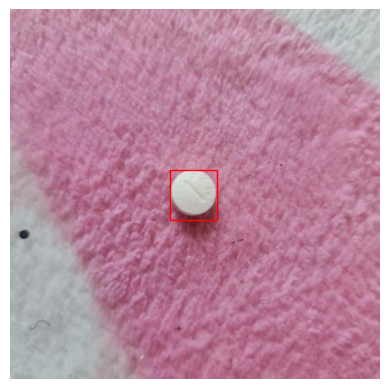

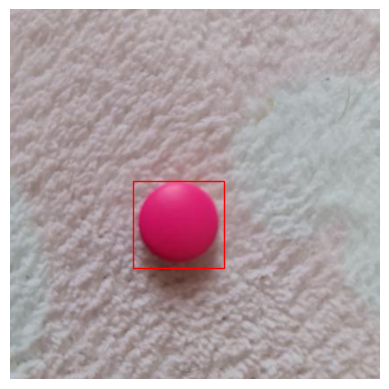

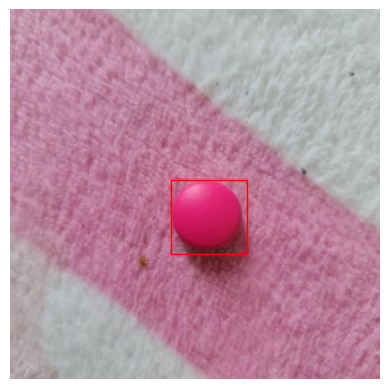

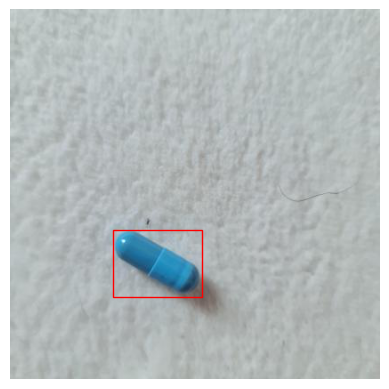

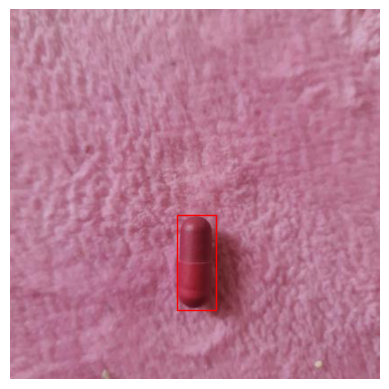

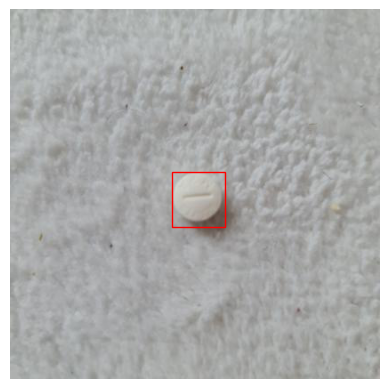

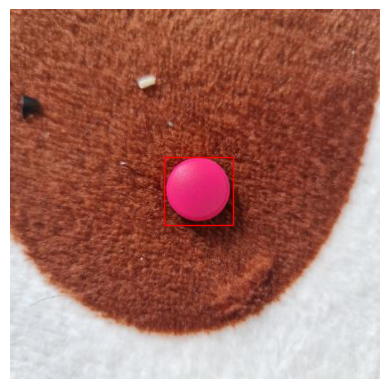

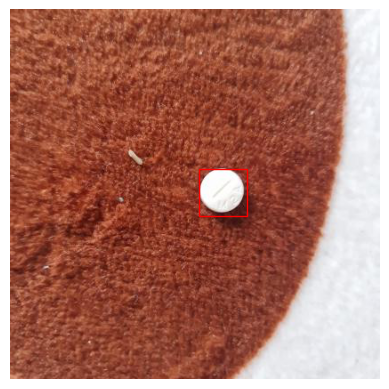

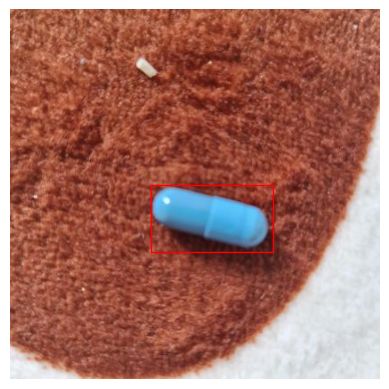

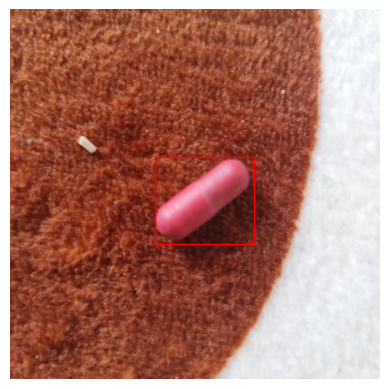

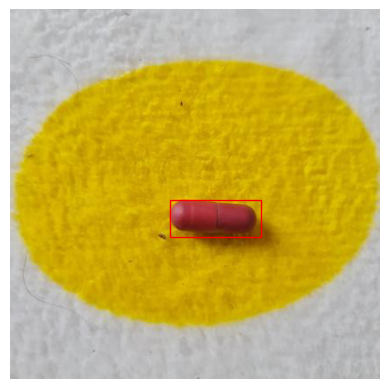

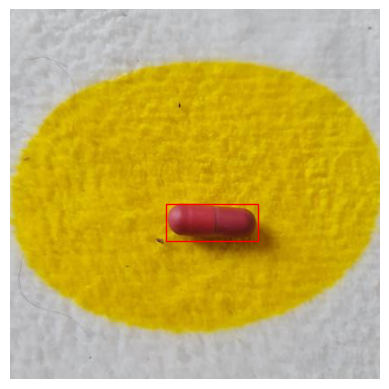

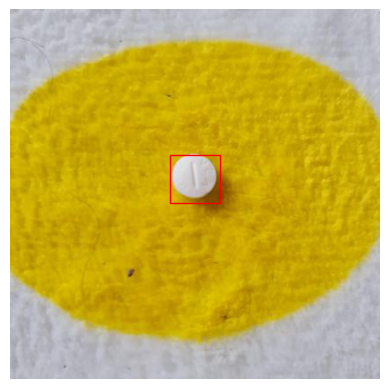

In [ ]:
for i in range(15):
  img =  np.asarray(Image.open(img_list[i]))
  # print(img_list[i])
  # print(np.shape(img))
  bboxes = get_bboxes(ann_list[i])
  plt.imshow(img)
  ax = plt.gca()

  for bbox in bboxes:
    x = bbox[0]
    y = bbox[1]
    width = bbox[2]-bbox[0]
    height = bbox[3]-bbox[1]
    rect = Rectangle((x, y),width,height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

  plt.axis('off')
  plt.show()

##statystyki

Wybrane przeze mnie statystyki to:
* rozmiar obrazów
* umieszczenie boundingboxów
* rozmiar boundinboxów
* ilość boundingboxów na obraz

In [ ]:
def bbox_size(coordinates):
  x_min, y_min, x_max, y_max = coordinates
  width = x_max-x_min
  height = y_max-y_min
  return width, height

def bbox_center_relative(bbox_coordinates, img_shape):
  bbox_w, bbox_h = bbox_size(bbox_coordinates)
  img_h, img_w, _ = img_shape
  return (bbox_coordinates[0]+bbox_w/2.)/img_w, (bbox_coordinates[1]+bbox_h/2.)/img_h



In [ ]:
shapes= []
centers = []
bbox_sizes = []
num_of_bboxes_per_image = []

for image, ann in zip(img_list, ann_list):
  img =  np.asarray(Image.open(image))
  shapes.append((np.shape(img)))

  bboxes = get_bboxes(ann)
  num_of_bboxes_per_image.append(len(bboxes))
  for bbox in bboxes:
    centers.append(bbox_center_relative(bbox, np.shape(img)))
    bbox_sizes.append(bbox_size(bbox))

# bbox_size_counter = Counter(bbox_sizes_list)
shapes_counter  = Counter(shapes)
num_of_bboxes_counter = Counter(num_of_bboxes_per_image)

In [ ]:
print(centers[0:3]) #umieszczenie środków bboxów
print(bbox_sizes[0:3]) #rozmiar bboxów
print(shapes_counter) #rozmiar obrazów ilość/rozmiar
print(num_of_bboxes_counter) #ilość bboxów/ ilość obrazów z ilością bboxów

[(0.5300480769230769, 0.53125), (0.5216346153846154, 0.5384615384615384), (0.4963942307692308, 0.5)]
[(51, 98), (76, 88), (53, 56)]
Counter({(416, 416, 3): 450, (417, 626, 3): 21, (1280, 960, 3): 14, (4032, 3024, 3): 9, (1936, 1936, 3): 6, (342, 608, 3): 4, (648, 1155, 3): 3, (469, 626, 3): 3, (360, 540, 3): 2, (600, 900, 3): 2, (339, 509, 3): 2, (408, 612, 3): 2, (160, 213, 3): 2, (3264, 2448, 3): 2, (1200, 1200, 3): 2, (573, 860, 3): 2, (480, 640, 3): 2, (335, 493, 3): 2, (470, 626, 3): 2, (400, 600, 3): 2, (480, 720, 3): 1, (550, 413, 3): 1, (228, 281, 3): 1, (566, 846, 3): 1, (246, 300, 4): 1, (200, 300, 3): 1, (350, 526, 3): 1, (258, 382, 3): 1, (987, 1480, 3): 1, (2329, 3500, 3): 1, (360, 640, 3): 1, (270, 340, 3): 1, (300, 300, 3): 1, (254, 375, 3): 1, (304, 468, 3): 1, (250, 400, 3): 1, (240, 420, 3): 1, (267, 400, 3): 1, (158, 210, 3): 1, (2129, 3200, 3): 1, (1024, 683, 3): 1, (4032, 2268, 3): 1, (1707, 1280, 3): 1, (550, 825, 3): 1, (1600, 1200, 3): 1, (1200, 730, 3): 1, (847

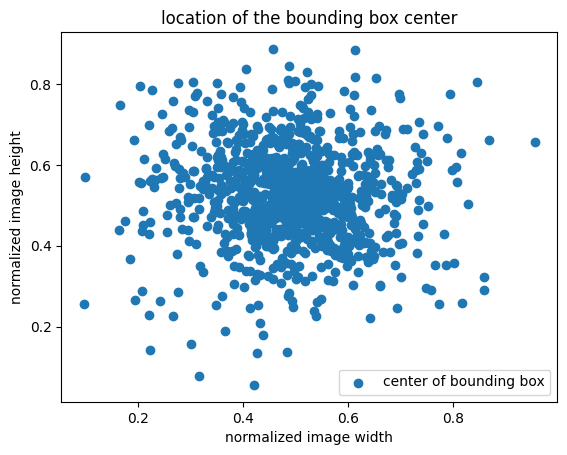

In [ ]:
plt.scatter(*zip(*centers), label='center of bounding box')
plt.xlabel('normalized image width')
plt.ylabel('normalized image height')
plt.legend()
plt.title('location of the bounding box center')
plt.show()

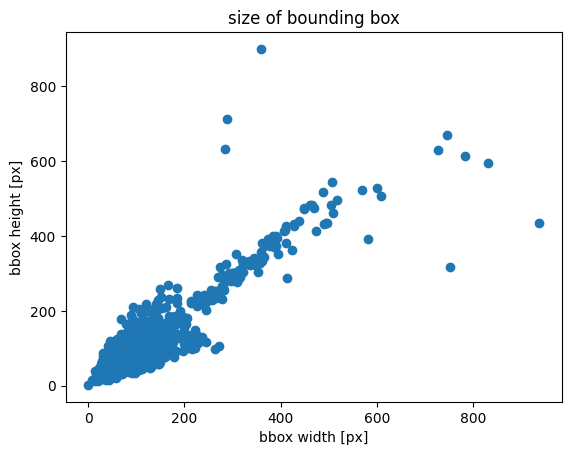

In [ ]:
plt.scatter(*zip(*bbox_sizes))
plt.xlabel('bbox width [px]')
plt.ylabel('bbox height [px]')
plt.title('size of bounding box')
plt.show()

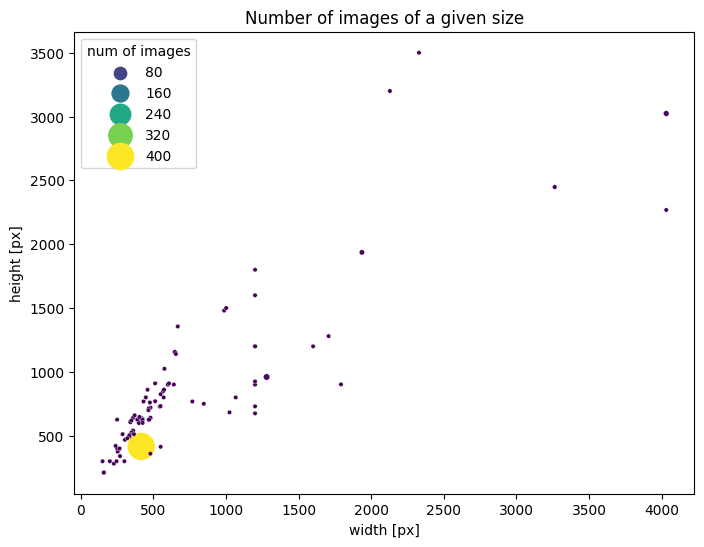

In [ ]:
x = []
y = []
for key in shapes_counter.keys():
  x.append(key[0])
  y.append(key[1])

d = {'width': x, 'height': y, 'num of images': shapes_counter.values()}
df = pd.DataFrame(data=d)

hue_order = list(shapes_counter.values())
hue_order.sort()
sns.scatterplot(data=df, x='width',y='height', hue='num of images', size='num of images', sizes=(10,400), hue_norm=(0, 400), palette='viridis')
plt.title('Number of images of a given size')
plt.xlabel('width [px]')
plt.ylabel('height [px]')
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()


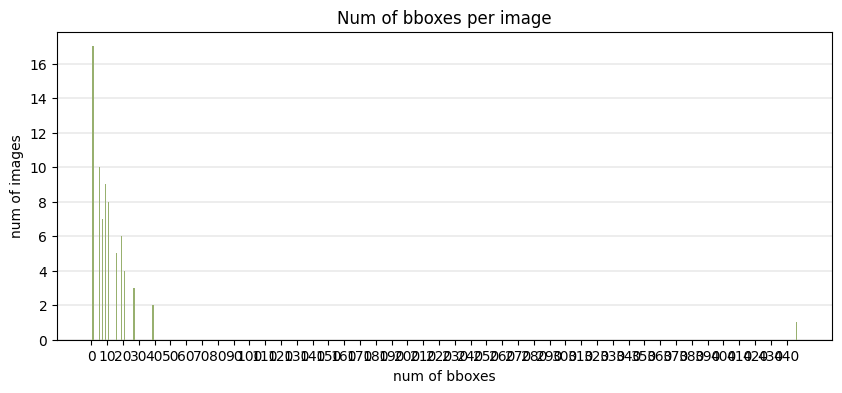

In [ ]:
plt.bar(num_of_bboxes_counter.values(), num_of_bboxes_counter.keys(), color='#98B06F', zorder=3)
plt.xlabel('num of bboxes')
plt.ylabel('num of images')
plt.xticks(np.arange(0, max(num_of_bboxes_counter.values())+1, step=10))
plt.yticks(np.arange(0, max(num_of_bboxes_counter.keys())+1, step=2))
plt.title('Num of bboxes per image')
fig = plt.gcf()
plt.grid(axis='y', color='grey', linewidth=0.2, zorder=0)
fig.set_size_inches(10,4)

#Załadowanie datasetu

Załadowanie datasetu:
- zdefiniuj batch_size
- zdefiniuj transformacje (np. normalizacja, augmentacja); pamiętaj, że dane muszą być zapisane w postaci tensorów
- wczytaj dataset z odpowiednimi właściwościami
- stwórz dataloader
- wczytaj bounding-boxy i klasy (target)

Dla większej przejrzystości możesz stworzyć osobną klasę o nazwie Dataset, która będzie tworzyła pary [image, target], gdzie target będzie słownikiem, w którym będą klasy, bounding-boxy czy inne informacje.

Klasa dataset  CONAJMNIEJ trzy fukcje:
* _ _ init _ _
* _ _ getitem _ _
* _ _ len _ _

In [ ]:
class PillsDataset(nn.Module):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.ann = list(sorted(os.listdir(os.path.join(root, "annotations"))))

    def __get_bboxes__(self, ann_path):

      tree = ET.parse(ann_path)
      root = tree.getroot()
      annotations = []
      for bndbox in root.iter('bndbox'):
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        if xmin>=xmax:
          xmin=xmax-1
        if ymin>=ymax:
          ymin=ymax-1

        annotations.append([xmin, ymin, xmax, ymax])
      return annotations

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        ann_path = os.path.join(self.root, "annotations", self.ann[idx])

        # img = cv2.imread(img_path)
        # print(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


        img = np.array(Image.open(img_path).convert("RGB"))


        boxes = self.__get_bboxes__(ann_path)
        # # convert everything into a torch.Tensor
        boxes = torch.tensor(boxes)
        # # there is only one class
        num_objs = len(boxes)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # labels_name = ['pill'*len(boxes)]


        image_id = torch.tensor([idx])
        # area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # if self.transforms is not None:

        transformed = self.transforms(image=img, bboxes = boxes)




        img = torch.tensor(transformed['image'], dtype=torch.float32)
        boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)

        img = img.to(device)
        target = {}
        target["boxes"] = boxes.to(device)
        target["labels"] = labels.to(device)
        target["image_id"] = image_id.to(device)
        # target['class'] = labels_name.to(device)
        # target["area"] = area

        return img, target


    def calc_mean(self):
      m_red = []
      m_green = []
      m_blue = []

      std_red = []
      std_green = []
      std_blue = []

      for idx in range(len(self.imgs)):
        img, _ = self.__getitem__(idx)
        img = img.cpu().detach().numpy()
        img = np.reshape(img, (3,np.shape(img)[0],np.shape(img)[1]))

        red = img[0]
        green = img[1]
        blue = img[2]

        sum_red = np.sum(red)
        sum_green = np.sum(green)
        sum_blue = np.sum(blue)

        m_red.append(sum_red/(np.shape(red)[0]*np.shape(red)[1]))
        m_green.append(sum_green/(np.shape(green)[0]*np.shape(green)[1]))
        m_blue.append(sum_blue/(np.shape(blue)[0]*np.shape(blue)[1]))

        std_red.append(np.std(red))
        std_green.append(np.std(green))
        std_blue.append(np.std(blue))


      m = [np.sum(m_red)/len(m_red), np.sum(m_green)/len(m_green), np.sum(m_blue)/len(m_blue)]
      std = [np.sum(std_red)/len(std_red), np.sum(std_green)/len(std_green), np.sum(std_blue)/len(std_blue)]
      print(m, std)

      #   m.append(img.cpu().detach().numpy())
      # m = np.mean(m, axis=2)
      # # m = np.sum(m, axis=1)
      # # np.shape(m)
      # print(np.shape(m))


    def __len__(self):
        return len(self.imgs)



In [ ]:
# dataset = PillsDataset('dataset/pillsPicture', get_transform(True))
# img, ann = dataset.__getitem__(0)
# print(img,"bla", ann)
# dataset.calc_mean()
# a = dataset.__getitem__(0)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def get_transform(train):
  if train:
    transform = A.Compose([A.Resize(224,224,3),
                           A.HorizontalFlip(p=0.5),
                           A.RandomBrightnessContrast(p=0.2),
                          #  A.Normalize(mean=(137, 143, 134), std=(50, 52, 48), max_pixel_value=255.0),
                          #  ToTensorV2(),
                           ],bbox_params=A.BboxParams(format='pascal_voc', label_fields = []))
  else:
    transform = A.Compose([A.Resize(224,224,3),
                          #  ToTensorV2(),
                          #  A.Normalize(mean=(137, 143, 134), std=(50, 52, 48), max_pixel_value=255.0),
                           ],
                           bbox_params=A.BboxParams(format='pascal_voc', label_fields = []))
  return transform

batch_size = 10

trainset = PillsDataset('dataset/pillsPicture', get_transform(True))
testset = PillsDataset('dataset/pillsPicture', get_transform(False))


idx = 30

indices = torch.randperm(len(trainset)).tolist()
trainset = torch.utils.data.Subset(trainset, indices[:-idx])
testset = torch.utils.data.Subset(testset, indices[-idx:])

a= 0.6

valset, testset = torch.utils.data.random_split(testset, [math.floor(len(testset)*a), len(testset)-math.floor(len(testset)*a)])


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

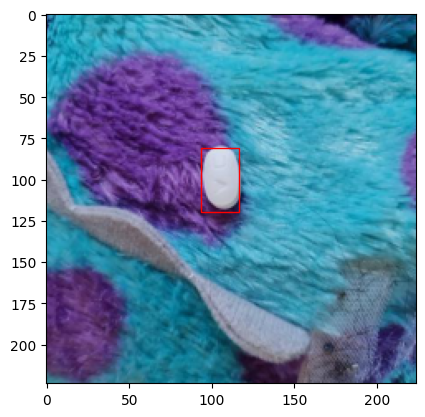

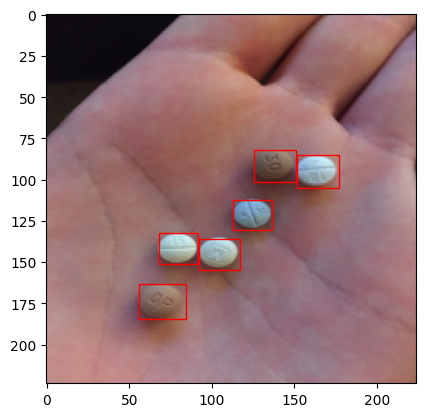

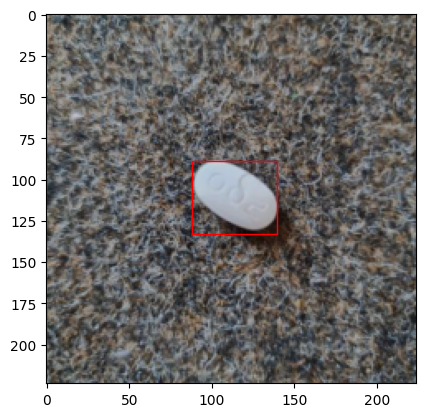

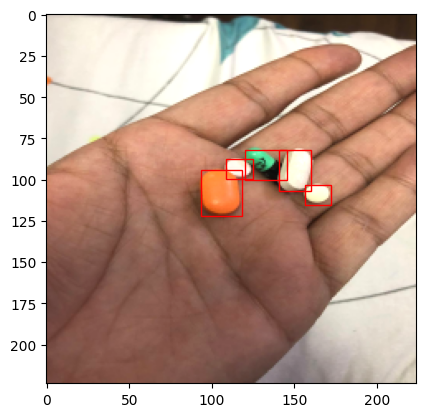

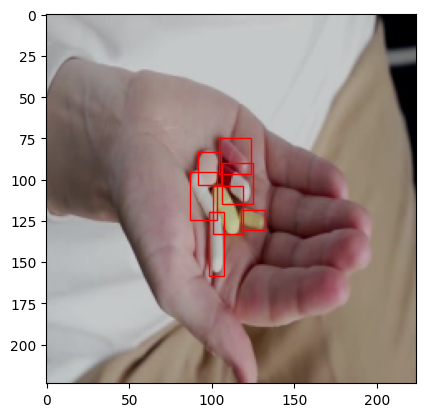

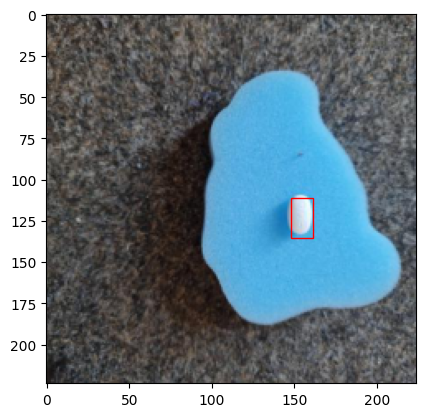

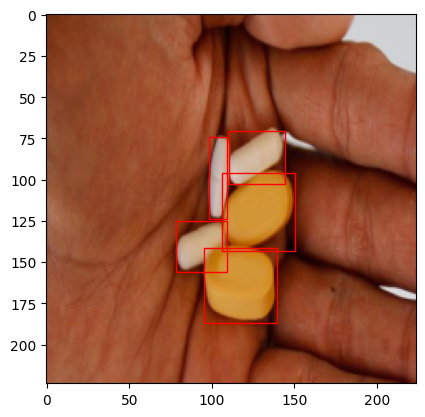

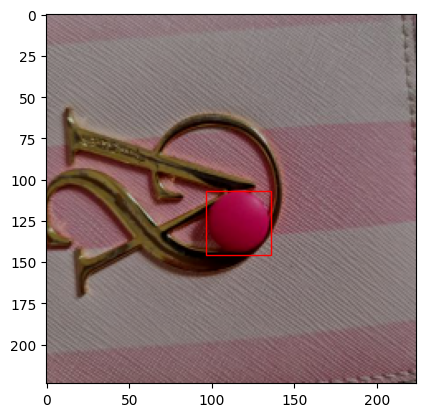

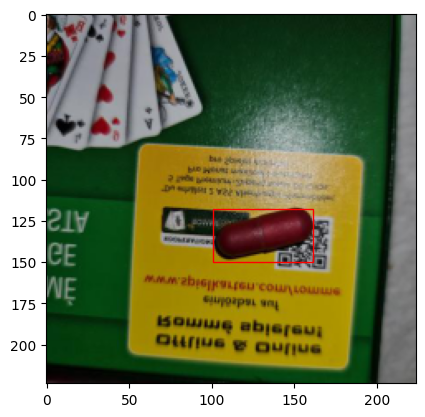

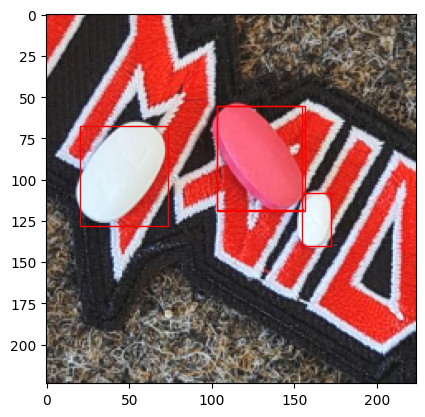

In [ ]:
x, y = next(iter(trainloader))


for i in range(batch_size):
  img = x[i].cpu().detach().numpy().astype(np.int32)
  ann = y[i]
  ann = ann['boxes'].cpu().detach().numpy()

  plt.imshow(img)
  ax = plt.gca()

  for bbox in ann:
    a = bbox[0]
    b = bbox[1]
    width = bbox[2]-bbox[0]
    height = bbox[3]-bbox[1]
    rect = Rectangle((a, b),width,height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

  plt.show()


Zdefiniuj swoją sieć:
- stwórz klasę, w której zdefiniujesz własną sieć
lub skorzystasz z już przeuczonej
- stwórz funkcję inicjującą warstwy sieci
- pamiętaj o stworzeniu funkcji forward,
  która odpowiada za przejście danych uczących przez sieć
- stwórz obiekt 'net' tej klasy

In [ ]:
def get_model():

  # load a model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT", max_size=224, min_size=224)

  # replace the classifier with a new one, that has
  # num_classes which is user-defined
  num_classes = 2  # 1 class (person) + background
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


  model = model.to(device)
  return model

Zdefiniuj funkcję celu oraz optymalizator:

In [ ]:
model = get_model()

params = [p for p in model.parameters() if p.requires_grad]

# optimizer = torch.optim.SGD(params, lr=0.00009, momentum = 0.0009, weight_decay=0.0006)
optimizer = torch.optim.Adam(params, lr=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                    step_size=3,
#                                                    gamma=0.1)

Zdefiniuj pętlę treningową:
- zdefiniuj liczbę epok - liczbę iteracji przejścia przez sieć
- zdefiniuj dane wejściowe w postaci [inputs, target]
- wyzeruj gradient
- podaj dane wejściowe na sieć
- oblicz loss
- dodaj optymalizację
- wyświetl statystyki dla tej epoki


In [ ]:
n = 25
val_loss_n = [100000, 99999]
train_loss_n = [100000, 99999]
for epoch in range(n):
  print(f'Epoch {epoch+1}/{n}')
  print('-' * 10)

  train_loss = []
  val_loss = []

  model.train()
  for inputs, targets in trainloader:

    inputs = [input.permute(2, 0, 1) for input in inputs]

    outputs = model(inputs, targets)

    losses = sum(loss for loss in outputs.values())
    loss_value = losses.item()
    # print(loss_value)

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    # lr_scheduler.step()

    train_loss.append(loss_value)

  with torch.no_grad():
    for inputs, targets in valloader:
      inputs = [input.permute(2, 0, 1) for input in inputs]
      outputs = model(inputs, targets)
      losses = sum(loss for loss in outputs.values())
      loss_value = losses.item()

      val_loss.append(loss_value)

    train_loss = np.sum(train_loss)/len(train_loss)
    val_loss = np.sum(val_loss)/len(val_loss)


    if val_loss < np.min(val_loss_n):
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            }, "/content/gdrive/MyDrive/Colab Notebooks/wagi/pills_model.pt")

    train_loss_n.append(train_loss)
    val_loss_n.append(val_loss)


  print(f'Training loss: {train_loss:.2f}, Validation loss: {val_loss:.2f}')



Epoch 1/25
----------
Training loss: 42.77, Validation loss: 5.27
Epoch 2/25
----------
Training loss: 1.02, Validation loss: 0.54
Epoch 3/25
----------
Training loss: 0.45, Validation loss: 0.55
Epoch 4/25
----------
Training loss: 0.43, Validation loss: 0.56
Epoch 5/25
----------
Training loss: 0.41, Validation loss: 0.45
Epoch 6/25
----------
Training loss: 0.38, Validation loss: 0.46
Epoch 7/25
----------
Training loss: 0.37, Validation loss: 0.40
Epoch 8/25
----------
Training loss: 0.34, Validation loss: 0.40
Epoch 9/25
----------
Training loss: 0.32, Validation loss: 0.43
Epoch 10/25
----------
Training loss: 0.32, Validation loss: 0.41
Epoch 11/25
----------
Training loss: 0.32, Validation loss: 0.42
Epoch 12/25
----------
Training loss: 0.31, Validation loss: 0.39
Epoch 13/25
----------
Training loss: 0.28, Validation loss: 0.36
Epoch 14/25
----------
Training loss: 0.27, Validation loss: 0.33
Epoch 15/25
----------
Training loss: 0.26, Validation loss: 0.50
Epoch 16/25
------

(2, 4)


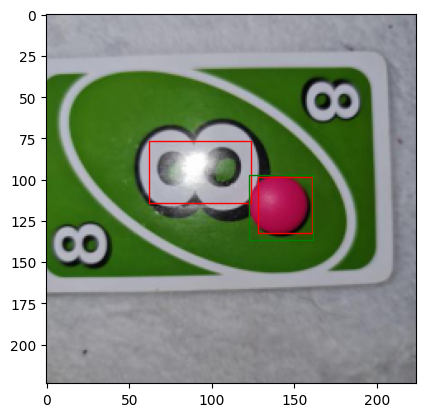

(1, 4)


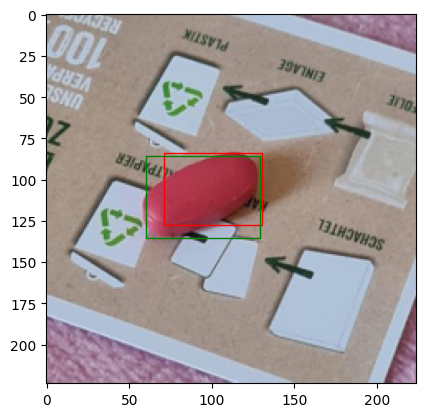

(1, 4)


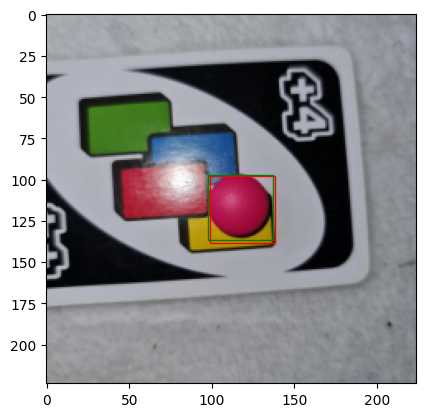

(1, 4)


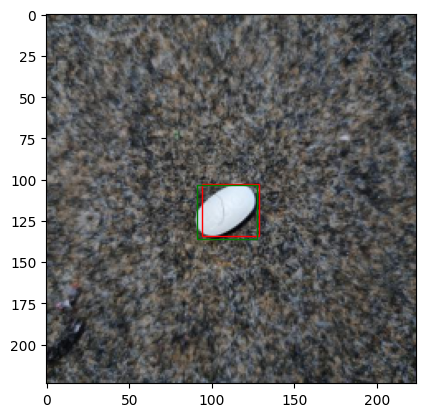

(1, 4)


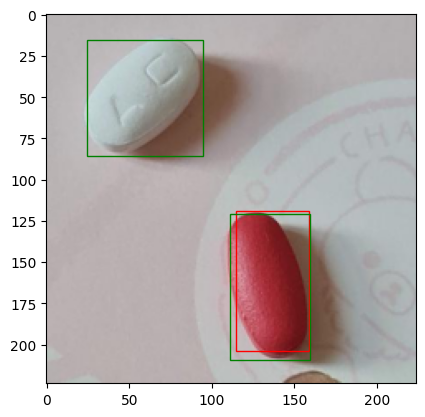

(2, 4)


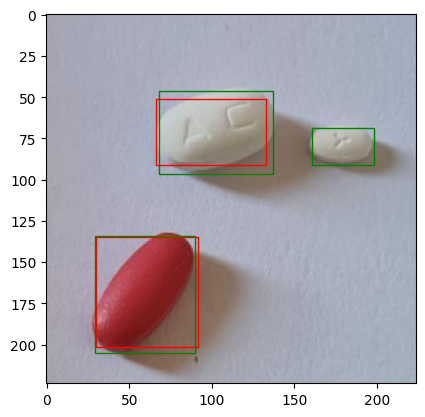

(1, 4)


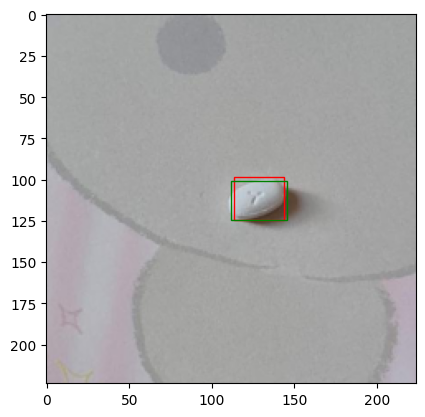

(1, 4)


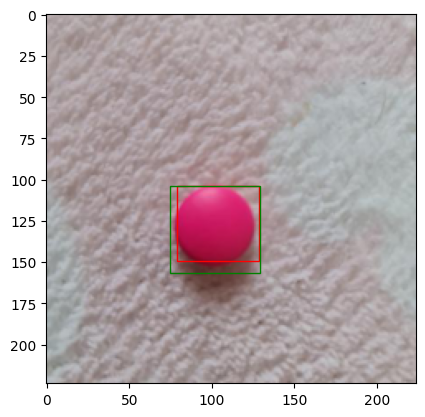

(3, 4)


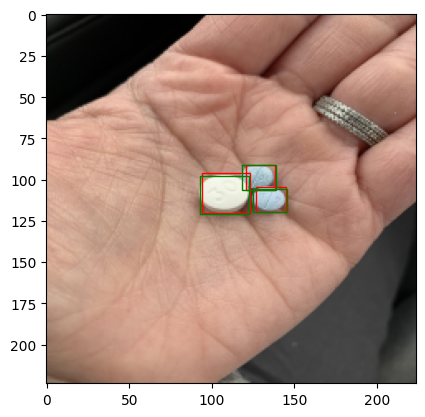

(1, 4)


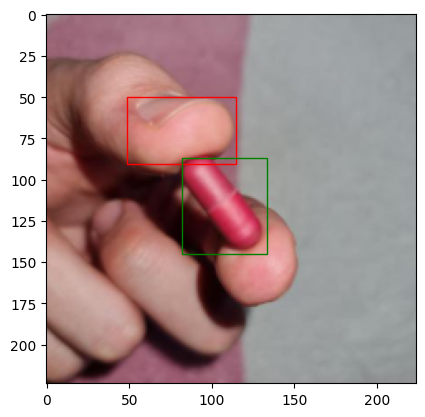

(1, 4)


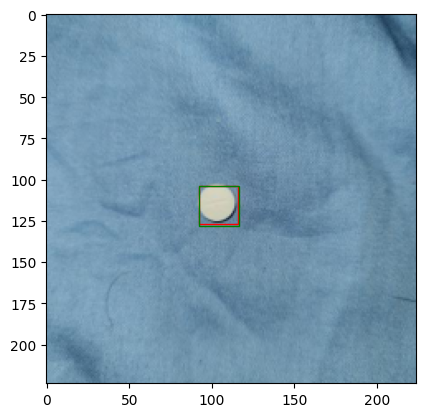

(4, 4)


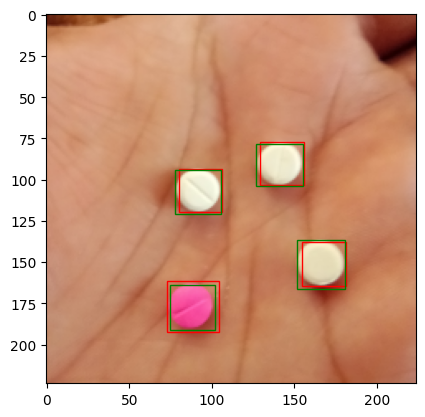

In [ ]:
model.eval()
for inputs, targets in testloader:

  images = []
  for img in inputs:
    images.append(img.cpu().detach().numpy())

  inputs = [input.permute(2, 0, 1) for input in inputs]

  outputs = model(inputs)

  for i, img in enumerate(images):
    out = outputs[i]

    gts = targets[i]
    gts = gts['boxes'].cpu().detach().numpy()


    boxes = out['boxes'].cpu().detach().numpy()
    scores = out['scores'].cpu().detach().numpy()
    out = boxes[scores>0.9]
    print(np.shape(out))

    plt.imshow(img.astype(np.int32))

    ax = plt.gca()

    for bbox in out:
      a = bbox[0]
      b = bbox[1]
      width = bbox[2]-bbox[0]
      height = bbox[3]-bbox[1]
      rect = Rectangle((a, b),width,height,linewidth=1,edgecolor='r',facecolor='none')
      ax.add_patch(rect)

    for bbox in gts:
      a = bbox[0]
      b = bbox[1]
      width = bbox[2]-bbox[0]
      height = bbox[3]-bbox[1]
      rect = Rectangle((a, b),width,height,linewidth=1,edgecolor='g',facecolor='none')
      ax.add_patch(rect)

    plt.show()

Zapisz wagi modelu

Wyświetl przykładowe obrazy:
- wczytaj wagi modelu
- przetestuj sieć na obrazach
- wyświetl obrazy
- wyświetl prawdziwe oznaczenia
- wyświetl predykcje wygenerowane przez sieć

Oblicz metryki:
- oblicz dokładność dla całego zbioru
- oblicz dokładność dla każdej z klas
- oblicz pozostałe metryki istotne dla ewaluacji detekcji